# Simple NLP modeling

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os, re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hyewon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyewon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data from directory

In [2]:
dataset = tf.keras.utils.get_file(fname = 'imdb.tar.gz',
                                 origin = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
                                 extract = True)

In [3]:
base_dir = os.path.dirname(dataset)
print(base_dir)

C:\Users\hyewon\.keras\datasets


In [4]:
def make_dict(dir):
    data = {}
    data['txt'] = []
    
    for i in os.listdir(dir):
        path = os.path.join(dir, i)
        rst = open(path, 'r', encoding = 'utf-8').read()
        data['txt'].append(rst)
        
    return pd.DataFrame.from_dict(data)

In [5]:
train_pos = make_dict(os.path.join(base_dir, 'aclImdb', 'train', 'pos'))
train_neg = make_dict(os.path.join(base_dir, 'aclImdb', 'train', 'neg'))
test_pos = make_dict(os.path.join(base_dir, 'aclImdb', 'test', 'pos'))
test_neg = make_dict(os.path.join(base_dir, 'aclImdb', 'test', 'neg'))

In [6]:
train_pos['label'] = 1
train_neg['label'] = 0
test_pos['label'] = 1
test_neg['label'] = 0

In [7]:
train_data = pd.concat([train_pos, train_neg])
test_data = pd.concat([test_pos, test_neg])

print(train_data.shape)
print(test_data.shape)

total_data = pd.concat([train_data, test_data])
print(total_data.shape)

(25000, 2)
(25000, 2)
(50000, 2)


## Natural Language Preprocessing
 + Remove stopwords
 + Tokenization
 + Create sequences from tokens

In [8]:
#set stopwords to english
stop = nltk.corpus.stopwords.words('english')
tokenizer=ToktokTokenizer()

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

total_data['new_txt'] = total_data['txt'].apply(remove_stopwords)

In [9]:
validation_samples = 10000
max_words = 10000
maxlen = 100

token = Tokenizer(num_words = max_words)
token.fit_on_texts(total_data['txt'].values)
sequence = token.texts_to_sequences(total_data['txt'].values)
word_index = token.word_index

In [10]:
labels = total_data['label'].values
data = pad_sequences(sequence, maxlen = maxlen)
print(data)
print(data.shape)

[[5799  469   68 ...   12    9  213]
 [ 111   10  255 ...    5  343  400]
 [   8 8161    1 ...    6  179  403]
 ...
 [ 105 1139  651 ...  126  338  156]
 [   3 1687    5 ...   62  178    5]
 [  82  454  104 ...   15   39 1070]]
(50000, 100)


In [11]:
# train - validation split
X_train = data[:25000]
y_train = labels[:25000]
X_val = data[25000:]
y_val = labels[25000:]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(25000, 100)
(25000,)
(25000, 100)
(25000,)


## Modeling

In [12]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 1,010,001
Trainable params: 1,010,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
es = EarlyStopping(patience = 3, monitor = 'val_loss')
rp = ReduceLROnPlateau(patience = 3, factor = 0.1)

In [14]:
model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'rmsprop')

In [15]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), callbacks = [es, rp])

Epoch 1/30
782/782 [==============================] - 8s 9ms/step - loss: 0.6080 - acc: 0.6586 - val_loss: 0.3452 - val_acc: 0.8478
Epoch 2/30
782/782 [==============================] - 7s 9ms/step - loss: 0.2921 - acc: 0.8801 - val_loss: 0.3165 - val_acc: 0.8599
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 0.2173 - acc: 0.9144 - val_loss: 0.3164 - val_acc: 0.8613
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 0.1679 - acc: 0.9389 - val_loss: 0.3293 - val_acc: 0.8578
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.1172 - acc: 0.9632 - val_loss: 0.3453 - val_acc: 0.8540
Epoch 6/30
782/782 [==============================] - 7s 9ms/step - loss: 0.0708 - acc: 0.9802 - val_loss: 0.3425 - val_acc: 0.8564


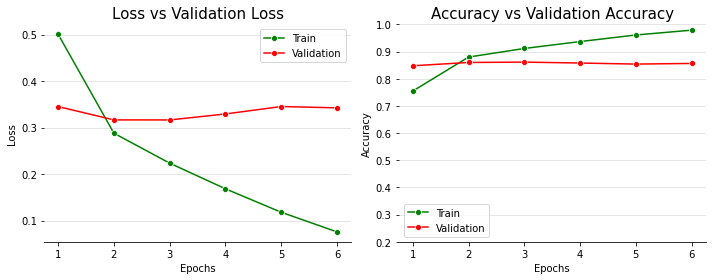

In [16]:
plt.figure(figsize = (10, 4))

epochs = history.epoch
epochs = [x+1 for x in epochs]

ax1 = plt.subplot(1, 2, 1)
sns.lineplot(epochs, history.history['loss'], marker = 'o', color = 'green', label = 'Train')
sns.lineplot(epochs, history.history['val_loss'], marker = 'o', color = 'red', label = 'Validation')
for s in ['top','left','right']:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('Loss vs Validation Loss', fontsize = 15); plt.xlabel('Epochs'); plt.ylabel('Loss')

ax2 = plt.subplot(1, 2, 2)
sns.lineplot(epochs, history.history['acc'], marker = 'o', color = 'green', label = 'Train')
sns.lineplot(epochs, history.history['val_acc'], marker = 'o', color = 'red', label = 'Validation')
for s in ['top','left','right']:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('Accuracy vs Validation Accuracy', fontsize = 15); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.ylim([0.2, 1])

plt.tight_layout()
plt.show()